In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

## Get data

In [2]:
from graphtda.datasets import get_dataset, read_classes
from graphtda.reader import tud_to_networkx

In [3]:
DATASET_NAME = 'IMDB-MULTI'

get_dataset(DATASET_NAME)
data = tud_to_networkx(DATASET_NAME)
y = read_classes(DATASET_NAME) - 1

u, values = np.unique(y, return_counts=True)
print(u, values)

[0 1 2] [500 500 500]


# 1-parameter filtrations

## Compute ECC - degree filtration

In [ ]:
from graphtda import FilteredGraph
from graphtda.graphtda import degree_filtration
from graphtda.bifiltration_utils import euler_characteristic_list_from_all, plot_euler_curve, EC_at_filtration

In [ ]:
ECC_list = []

for G in tqdm(data):
    fg = FilteredGraph(G, filtration_function=degree_filtration)
    ecc_contributions = fg.compute_ECP()

    ECC_list.append(euler_characteristic_list_from_all(ecc_contributions))

In [ ]:
fig, ax = plt.subplots()
for ecc in ECC_list:
    plot_euler_curve(ecc, with_lines=True, this_ax=ax)

### Vectorize

In [ ]:
# lets find the max filtration value
max_f = max([c[-1][0] for c in ECC_list])
max_f

In [ ]:
# lets sample the ECCs
X = np.array([ [EC_at_filtration(ecc, i) for i in range(max_f+1)] for ecc in ECC_list])
X.shape

### Classify

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
train_accuracy_SVM = []
test_accuracy_SVM = []

skf = StratifiedKFold(n_splits=5)
        
for train, test in tqdm(skf.split(X, y)):
    
    SVM_classifier = svm.SVC(kernel='rbf', 
                            class_weight='balanced', 
                            C=1,
                            random_state=42)
    SVM_classifier.fit(X[train], y[train])
    train_accuracy_SVM.append(SVM_classifier.score(X[train], y[train]))
    test_accuracy_SVM.append(SVM_classifier.score(X[test], y[test]))


print("TRAIN: {:.3} \pm {:.3}".format(np.mean(train_accuracy_SVM), np.std(train_accuracy_SVM)))
print("TEST: {:.3} \pm {:.3}".format(np.mean(test_accuracy_SVM), np.std(test_accuracy_SVM)))

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
train_accuracy_LDA = []
test_accuracy_LDA = []

skf = StratifiedKFold(n_splits=5)
        
for train, test in tqdm(skf.split(X, y)):
    
    ldr_classifier = LinearDiscriminantAnalysis()

    ldr_classifier.fit(X[train], y[train])
    train_accuracy_LDA.append(ldr_classifier.score(X[train], y[train]))
    test_accuracy_LDA.append(ldr_classifier.score(X[test], y[test]))


print("TRAIN: {:.3} \pm {:.3}".format(np.mean(train_accuracy_LDA), np.std(train_accuracy_LDA)))
print("TEST: {:.3} \pm {:.3}".format(np.mean(test_accuracy_LDA), np.std(test_accuracy_LDA)))

# 2-parameter filtrations

In [4]:
from graphtda import FilteredGraph
from graphtda.graphtda import hks, ollivier_ricci_curvature, degree_filtration
from graphtda.graphtda import product_bifiltration, interlevel_bifiltration, HKS_bifiltration

from graphtda.bifiltration_utils import discretize_graded_rank

In [5]:
hilbert_0 = []
hilbert_1 = []

for G in tqdm(data):
    #FG1 = FilteredGraph(G, hks, t=10)
    #FG2 = FilteredGraph(G, ollivier_ricci_curvature, alpha=0.5)

    #FG3 = FilteredGraph(G, degree_filtration)

    #FG = FilteredGraph(G, product_bifiltration, G1=FG1, G2=FG2)

    FG = FilteredGraph(G, HKS_bifiltration)

    FG.compute_bipersistence(dim=0, x=100,y=100)
    hilbert_0.append(FG.betti)

    FG.compute_bipersistence(dim=1, x=100,y=100)
    hilbert_1.append(FG.betti)

import pickle

with open('pkl/{}_hks_bi_0'.format(DATASET_NAME), 'wb') as f0:
    pickle.dump(hilbert_0, f0)

with open('pkl/{}_hks_bi_1'.format(DATASET_NAME), 'wb') as f1:
    pickle.dump(hilbert_1, f1)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [6]:
import pickle 

with open('pkl/{}_hks_bi_0'.format(DATASET_NAME), 'rb') as f0:
    hilbert_0 = pickle.load(f0)

with open('pkl/{}_hks_bi_1'.format(DATASET_NAME), 'rb') as f1:
    hilbert_1 = pickle.load(f1)

In [7]:
x_min_0, x_max_0 = (min([float(min(betti.dimensions.x_grades)) for betti in hilbert_0]), 
                max([float(max(betti.dimensions.x_grades)) for betti in hilbert_0])
)

y_min_0, y_max_0 = (min([float(min(betti.dimensions.y_grades)) for betti in hilbert_0]), 
                max([float(max(betti.dimensions.y_grades)) for betti in hilbert_0])
)

print(x_min_0, x_max_0)
print(y_min_0, y_max_0)

x_min_1, x_max_1 = (min([float(min(betti.dimensions.x_grades)) for betti in hilbert_1]), 
                max([float(max(betti.dimensions.x_grades)) for betti in hilbert_1])
)

y_min_1, y_max_1 = (min([float(min(betti.dimensions.y_grades)) for betti in hilbert_1]), 
                max([float(max(betti.dimensions.y_grades)) for betti in hilbert_1])
)

print(x_min_1, x_max_1)
print(y_min_1, y_max_1)

0.01000099 1.0
0.1 10.0
0.01000099 1.0
0.1 10.0


In [8]:
x_grid = np.linspace(x_min_0, x_max_0, num=50)
y_grid = np.linspace(y_min_0, y_max_0, num=50)

grid_hilbert_0 = np.array([discretize_graded_rank(betti, x_grid, y_grid, i) for i, betti in tqdm(enumerate(hilbert_0))])
grid_hilbert_1 = np.array([discretize_graded_rank(betti, x_grid, y_grid, i) for i, betti in tqdm(enumerate(hilbert_1))])

hilbert_stack = np.stack((grid_hilbert_0, grid_hilbert_1), axis=1)
hilbert_stack.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1500, 2, 50, 50)

Text(0.5, 1.0, 'hilbert 1 class 2')

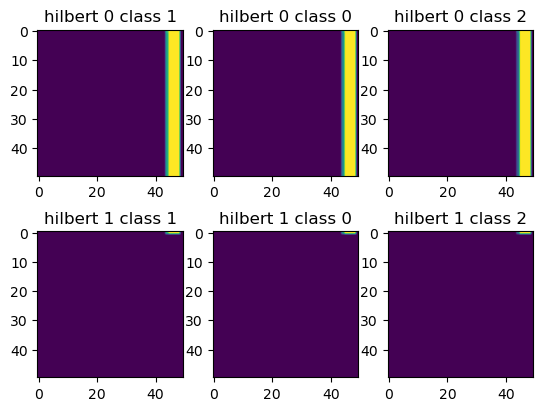

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=2)

axs[0, 0].imshow(np.mean(grid_hilbert_0[y == 1], axis=0))
axs[0, 0].set_title('hilbert 0 class 1')
axs[0, 1].imshow(np.mean(grid_hilbert_0[y == 0], axis=0))
axs[0, 1].set_title('hilbert 0 class 0')
axs[0, 2].imshow(np.mean(grid_hilbert_0[y == 2], axis=0))
axs[0, 2].set_title('hilbert 0 class 2')

axs[1, 0].imshow(np.mean(grid_hilbert_1[y == 1], axis=0))
axs[1, 0].set_title('hilbert 1 class 1')
axs[1, 1].imshow(np.mean(grid_hilbert_1[y == 0], axis=0))
axs[1, 1].set_title('hilbert 1 class 0')
axs[1, 2].imshow(np.mean(grid_hilbert_1[y == 2], axis=0))
axs[1, 2].set_title('hilbert 1 class 2')

## ConvNN 

In [10]:
from CNN_model import train_CNN

train_accuracy_CNN, test_accuracy_CNN = train_CNN(hilbert_stack, y, num_epochs=50)

The model will be running on cpu device


0it [00:00, ?it/s]

TRAIN 0.412  TEST 0.433
TRAIN 0.427  TEST 0.42
TRAIN 0.43  TEST 0.413
TRAIN 0.425  TEST 0.367
TRAIN 0.414  TEST 0.437


In [11]:
print("TRAIN: {:.3} \pm {:.3}".format(np.mean(train_accuracy_CNN)*100, np.std(train_accuracy_CNN)*100 ))
print("TEST: {:.3} \pm {:.3}".format(np.mean(test_accuracy_CNN)*100, np.std(test_accuracy_CNN)*100 ))

TRAIN: 42.2 \pm 0.701
TEST: 41.4 \pm 2.52
